<a href="https://colab.research.google.com/github/danfolador/REDES/blob/main/REDES_Exercicio03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EXERCÍCIO 03**

Aluno: Daniel Folador Rossi

Matrícula: 20201mpca0306

---

Quando usamos uma arquitetura de rede neural com pelo menos uma camada oculta, os pesos da camada de saída não são mais ajustados às características da camada de entrada, mas utilizam outro espaço de características, normalmente, de maior dimensão. Mesmo que tenhamos apenas duas características de de entrada, podemos ter vários vetores na camada de saída. Por isso, não é possível plotar os vetores da camada de saída.

Esta atividade consiste em plotar a região de decisão da ELM mostrada no vídeo.

In [1]:
#======================================================
# INICIALIZAÇÃO
#======================================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.preprocessing import label_binarize 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
#======================================================
# FUNCOES AUXILIARES
#======================================================
def GeraDataSet_SepLin(tamanho=20, centros=4, random_state=None):
    X, y = make_blobs(n_samples=tamanho, centers=centros, center_box=(0,1.0), cluster_std=0.05, random_state=random_state)
    return X, y

def GeraDataSet_NaoSepLin(tamanho=20, centros=[[0,0],[1,0],[1,1],[0,1]], random_state=None):
    X, y = make_blobs(n_samples=tamanho, centers=centros, cluster_std=0.05, random_state=random_state)
    y = np.array(y%2, dtype=int)
    return X, y

def PlotaDataSet(X, y, transp):
    #plota pra cada classe
    for k in set(y):
        logic = y==k
        plt.plot(X[:,0][logic], X[:,1][logic], 'o', alpha=transp)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim([-0.3,1.2])
    plt.ylim([-0.3,1.2])

def PlotaVetor(vetor, cor='k', transp=1.0):
    origem= [0,0]
    plt.arrow(*origem, *vetor, color=cor, alpha=transp)

def PlotaHiperplano(vetor, bias=0, xmin=-0.1, xmax=1.2):
    xs = np.linspace(xmin,xmax,num=2)
    ys = (-vetor[0]/vetor[1])* xs - bias / vetor[1]
    plt.plot(xs,ys)

def Perpendicular(vetor):
    perpend = np.array(vetor[::-1])
    perpend[0] *= -1
    return perpend

def CriaCategoricos(y):
    replacements = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f'}
    replacer = replacements.get
    y = [replacer(n, n) for n in y]
    return y

def TrataRotulos(y):
    # Substitui por rótulos numéricos
    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)
    
    # Para o caso binário, substitui por -1/+1
    if len(set(y))<=2: y = y*2-1
    return y

In [3]:
#======================================================
# FUNÇÕES DE CUSTO
#======================================================
from sklearn.base import BaseEstimator, ClassifierMixin

# PERCEPTRON
#--------------------------------------------------
class CustoPerceptron():
    @staticmethod
    def Erro(y, ypred):
        return y - ypred
    @staticmethod
    def Custo(y, ypred):
        return np.sum(CustoPerceptron.Erro(y, ypred)**2)
    @staticmethod
    def Gradiente(y, ypred, X):
        return np.matmul(X.T, CustoPerceptron.Erro(y, ypred))

# HINGELOSS
#--------------------------------------------------
class HingeLoss():
    @staticmethod
    def Erro(y, ypred):
        return np.multiply(y, ypred)
    @staticmethod
    def Custo(y, ypred):
        return np.sum(1 - HingeLoss.Erro(y, ypred))
    @staticmethod
    def Gradiente(y, ypred, X):
        marginais = HingeLoss.Erro(y, ypred) < 1
        return np.matmul(y[marginais],X[marginais])

# ADALINE
#--------------------------------------------------
class Adaline():
    def __init__(self):
        self.preactivated = True
    @staticmethod
    def Erro(y, ypred):
        return y - ypred
    @staticmethod
    def Custo(y, ypred):
        return np.sum((1 - Adaline.Erro(y, ypred))**2)
    @staticmethod
    def Gradiente(y, ypred, X):
        return np.matmul(X.T, Adaline.Erro(y, ypred))

In [4]:
#======================================================
# ALGORITMOS
#======================================================

# DESCIDA DE GRADIENTE
#--------------------------------------------------
class DescidaGradiente():
    def __init__(self, custo, maxiter=1000, alpha=0.01):
        self.custo = custo
        self.maxiter = maxiter
        self.alpha = alpha
        
    def getw(self, X, y, activation=lambda a: a):
        w = np.random.uniform(-1, 1,size=(X.shape[1], y.shape[1]))
        
        for _ in range(self.maxiter):
            ypred = activation(np.matmul(X, w))
            custo = self.custo.Custo(y, ypred)
            if custo==0:
                break
            w = w + self.alpha * self.custo.Gradiente(y, ypred, X)
        return w


# PSEUDO-INVERSA
#--------------------------------------------------
class PseudoInversa():
    def __init__(self):
        pass
    def getw(self, X, y):
        w = np.random.uniform(-1, 1,size=(X.shape[1], y.shape[1]))
        pinv = np.linalg.pinv(X)
        w = np.matmul(pinv, y)
        return w

In [5]:
#======================================================
# PERCEPTRON
#======================================================
class Perceptron(BaseEstimator, ClassifierMixin):
    
    # INIT
    #--------------------------------------------------
    def __init__(self, algoritmo, threshold):
        self.w = None
        self.threshold = threshold
        self.activation = lambda a: (a>=0)*2 -1
        self.algoritmo = algoritmo
    
    # BIAS
    #--------------------------------------------------
    @staticmethod
    def includebias(X):
        bias = np.ones((X.shape[0],1))
        Xb = np.concatenate((bias,X), axis=1)
        return Xb

    # FIT
    #--------------------------------------------------        
    def fit(self,X,y):
        
        X = Perceptron.includebias(X)
        self.labels = list(set(y))

        y = label_binarize(y, classes=self.labels)*2-1
        
        #if len(self.labels)==2: y = y[:,0:1]

        # Treinamento
        if hasattr(self.algoritmo, 'custo') and not (hasattr(self.algoritmo.custo, 'preactivated') and self.algoritmo.custo.preactivated):
            self.w = self.algoritmo.getw(X, y, self.activation)    
        else:
            self.w = self.algoritmo.getw(X, y)


    # PREDICT
    #--------------------------------------------------     
    def predict(self,X):
        Xb = Perceptron.includebias(X)
        a = np.matmul(Xb, self.w)
            
        #Caso binário
        if self.w.shape[1]<=1:
            logic = self.activation(a) > self.threshold
            idx = np.array(logic, dtype=int)[:,0]
        #Caso multiclasse
        else:
            idx = np.argmax(a, axis=1)
        
        ypred = np.array([self.labels[i] for i in idx])     

        return ypred
    

# %%
#======================================================
# ELM
#======================================================
from scipy.special import expit


def tanh(a):
    return expit(a)*2-1

class ExtremeLearningMachine(BaseEstimator, ClassifierMixin):
    
    # INIT
    #--------------------------------------------------
    def __init__(self, algoritmo=PseudoInversa(), threshold=0):
        self.wih = None
        self.w = None
        self.threshold = threshold
        #self.activation = lambda a: (a>=0)*2 -1
        self.activation = tanh
        self.algoritmo = algoritmo
    
    # BIAS
    #--------------------------------------------------
    @staticmethod
    def includebias(X):
        bias = np.ones((X.shape[0],1))
        Xb = np.concatenate((bias,X), axis=1)
        return Xb

    # FIT
    #--------------------------------------------------        
    def fit(self,X,y):
        
        #Pesos de input da camada hidden
        #vamos usar k vezes o número de características de X
        k = 3
        self.wih = np.random.uniform(size=(X.shape[1], X.shape[1]*k))
        Xh = np.matmul(X, self.wih)
        Xho = self.activation(Xh)
        X = ExtremeLearningMachine.includebias(Xho)
        
        self.labels = list(set(y))
        y = label_binarize(y, classes=self.labels)*2-1
        
        # Treinamento
        if hasattr(self.algoritmo, 'custo') and not (hasattr(self.algoritmo.custo, 'preactivated') and self.algoritmo.custo.preactivated):
            self.w = self.algoritmo.getw(X, y, self.activation)    
        else:
            self.w = self.algoritmo.getw(X, y)


    # PREDICT
    #--------------------------------------------------     
    def predict(self,X):
        Xh = np.matmul(X, self.wih)
        Xho = self.activation(Xh)       
        Xb = ExtremeLearningMachine.includebias(Xho)  #Vamos usar o bias apenas na camada de saída
        a = np.matmul(Xb, self.w)
            
        #Caso binário
        if self.w.shape[1]<=1:
            logic = self.activation(a) > self.threshold
            idx = np.array(logic, dtype=int)[:,0]
        #Caso multiclasse
        else:
            idx = np.argmax(a, axis=1)
        
        ypred = np.array([self.labels[i] for i in idx])     

        return ypred

In [6]:
#======================================================
# FUNCAO AJUSTE
#======================================================
def Ajuste(Xtrain, Xtest, ytrain, ytest, modelo, plota_vetor):

    # AJUSTE
    #------------------------------------------------------      
    modelo.fit(Xtrain, ytrain)
    ypred = modelo.predict(Xtest)             #Prediçao com resubstituição
    acuracia = sum(ytest==ypred)/len(ytest)
   
    # PLOT DE RESULTADOS
    #------------------------------------------------------  
    xannoate = -0.20
    yannoate = -0.25
    plt.annotate('acuracia= ' + str(acuracia), (xannoate,yannoate), color='red')
    PlotaDataSet(Xtest, ytest, transp=0.3)

    # Caso Binário
    if len(set(ytest))<=2:
        pesos = modelo.w[1:]
        bias = modelo.w[0]
        if plota_vetor: PlotaHiperplano(pesos,bias)
       
    # Caso Multiclasse
    else:
        for i in range(len(set(ytest))):
            pesos = modelo.w[1:,i]
            bias = modelo.w[0,i]
            if plota_vetor: PlotaHiperplano(pesos, bias)

    plt.show()

    pesos = modelo.w[1:]
    bias = modelo.w[0]

    
    return pesos, bias, acuracia

In [7]:
#======================================================
# BANCO DE DADOS
#======================================================   
# Gera dados
n_classes = [[0,0],[1,0],[1,1],[0,1]]
lin_sep = 0

#Linearmente Separados
if lin_sep:
    X, y = GeraDataSet_SepLin(200, centros=n_classes, random_state=42)    

#Não-Linearmente Separados
else:
    X, y = GeraDataSet_NaoSepLin(200, centros=n_classes, random_state=42)   

y = CriaCategoricos(y)
df1 = pd.DataFrame(X, columns=['X1','X2'])
df2 = pd.DataFrame(y, columns=['y'])
df = pd.concat([df1, df2],axis=1)
print('============================')
print('DADOS BRUTOS MULTICLASSE')
print('============================')
print(df.head(10))
print()

DADOS BRUTOS MULTICLASSE
         X1        X2  y
0  1.070140 -0.070093  b
1  0.990382  0.015077  b
2  0.073282 -0.011289  a
3  0.016136  0.958638  b
4  1.010705 -0.062287  b
5  0.045770  0.016438  a
6  1.002910 -0.057149  b
7  0.963482  1.010823  a
8  0.966911  1.042622  a
9  0.984237  1.037948  a



In [8]:
#======================================================
# TRATAMENTO DOS DADOS
#======================================================   
y=TrataRotulos(y)

df1 = pd.DataFrame(X, columns=['X1','X2'])
df2 = pd.DataFrame(y, columns=['y'])
df = pd.concat([df1, df2],axis=1)
print('============================')
print('DADOS MULTICLASSE TRATADOS')
print('============================')
print(df.head(10))
print()

DADOS MULTICLASSE TRATADOS
         X1        X2  y
0  1.070140 -0.070093  1
1  0.990382  0.015077  1
2  0.073282 -0.011289 -1
3  0.016136  0.958638  1
4  1.010705 -0.062287  1
5  0.045770  0.016438 -1
6  1.002910 -0.057149  1
7  0.963482  1.010823 -1
8  0.966911  1.042622 -1
9  0.984237  1.037948 -1



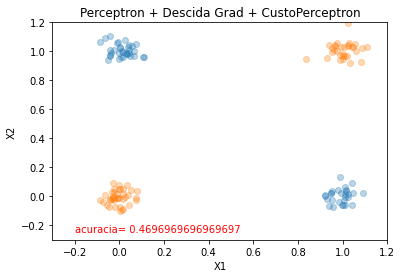


Perceptron + Descida Grad + CustoPerceptron
--------------------------------------------
bias= [-0.5819655]
pesos= [[-0.13652312]
 [ 0.29798321]]
acuracia= 0.4696969696969697



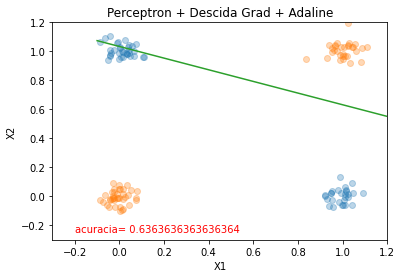


Perceptron + Descida Grad + Adaline
--------------------------------------------
bias= [-0.44027709]
pesos= [[0.17125412]
 [0.42592351]]
acuracia= 0.6363636363636364



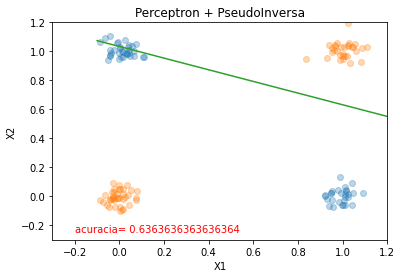


Perceptron + PseudoInversa
--------------------------------------------
bias= [-0.44027709]
pesos= [[0.17125412]
 [0.42592351]]
acuracia= 0.6363636363636364



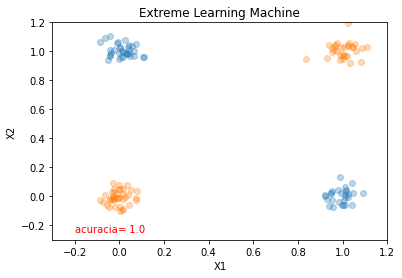


Extreme Learning Machine
--------------------------------------------
bias= [0.97183299]
pesos= [[ 116.0891018 ]
 [ -51.73095026]
 [1216.8870894 ]
 [-506.09760544]
 [-227.09274126]
 [-769.34465121]]
acuracia= 1.0



In [11]:
#======================================================
# RODADAS
#======================================================
alpha = 0.01
maxiter = 1000
threshold = 0
modelo1 = Perceptron(DescidaGradiente(CustoPerceptron(), maxiter, alpha), threshold)
modelo2 = Perceptron(DescidaGradiente(Adaline(), maxiter, alpha), threshold)
modelo3 = Perceptron(PseudoInversa(),threshold)
modelo4 = ExtremeLearningMachine(PseudoInversa(),threshold)

modelos = [modelo1, modelo2, modelo3, modelo4]
titulos = ['Perceptron + Descida Grad + CustoPerceptron',
           'Perceptron + Descida Grad + Adaline',
           'Perceptron + PseudoInversa',
           'Extreme Learning Machine']

plota_vetor=[True,True,True,False]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.66)

for modelo, titulo,bol in zip(modelos,titulos,plota_vetor):
    plt.title(titulo)
    pesos, bias, acuracia = Ajuste(Xtrain, Xtest, ytrain, ytest, modelo, bol)


    print()
    print(titulo)
    print('--------------------------------------------')
    print('bias=', bias)
    print('pesos=', pesos)
    print('acuracia=', acuracia)
    print()

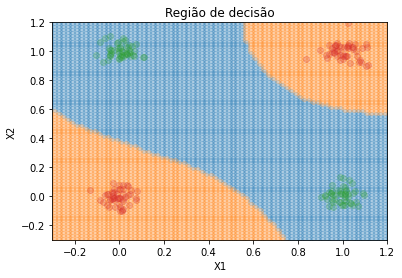

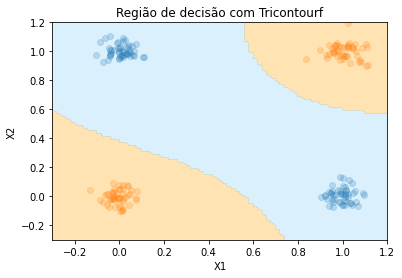

In [12]:
#======================================================
# REGIÃO DE DECISÃO
#======================================================

# PREPARAÇÃO
#------------------------------------------------------ 
h = 0.02
x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                       np.arange(x2_min, x2_max, h))

Xreg = np.c_[xx1.ravel(), xx2.ravel()]
yreg = modelo.predict(Xreg)

# PLOT COM SCATTERPLOT
#------------------------------------------------------  
plt.title('Região de decisão')
PlotaDataSet(Xreg, yreg, transp=.2)
PlotaDataSet(X, y, transp=.2)
plt.show()

# PLOT COM TRICONTOURF
#------------------------------------------------------ 
from matplotlib.colors import ListedColormap
levels=np.linspace(-1.01,1.01,3)
cmap=ListedColormap(['orange','lightskyblue'])

plt.title('Região de decisão com Tricontourf')
PlotaDataSet(X, y, transp=.2)
plt.tricontourf(Xreg[:,0], Xreg[:,1], yreg, cmap=cmap, levels=levels, alpha=0.3)
